Enter modulation index: 0.44
Enter phase difference in degrees: 20
Enter frequency (Hz): 78
Frequency too high for the program, Please try a lower frequency, Sampling time limitations:  
Enter frequency (Hz): 67
Enter Vdc: 500


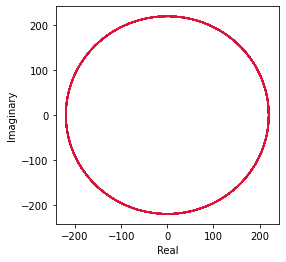

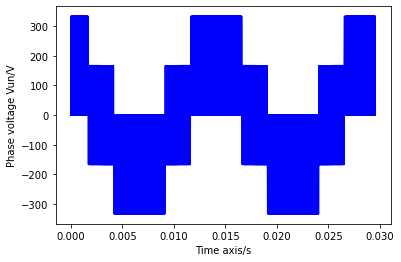

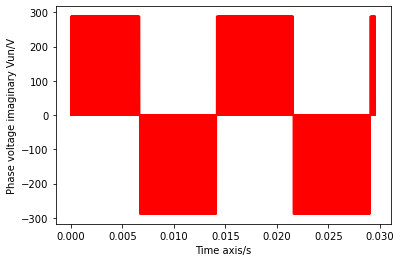

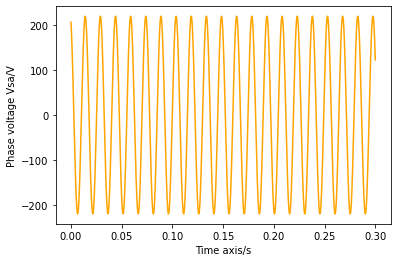

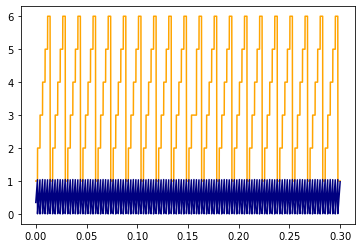

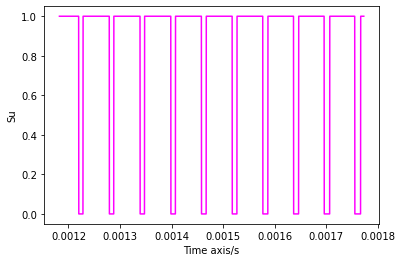

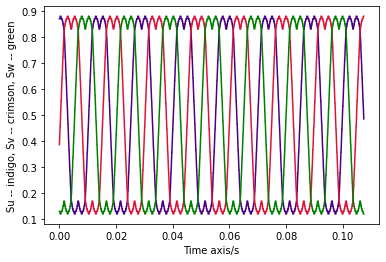

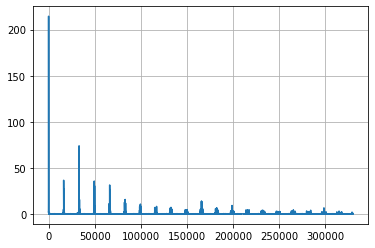

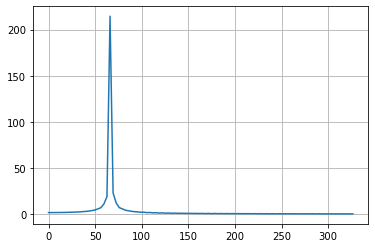

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import math as mt
import cmath as cmt
import scipy.integrate as odeint
%matplotlib inline
from scipy import fftpack
from scipy.fft import fft, ifft



def generate_phased_output(state,Ma,Vdc,Alpha,frequency,carrier_frequency, data_pts):
    Ts = 1.0 / carrier_frequency
    v_vect = Ma * Vdc
    states_right = []
    states_left = []
    Vect_values = []
    t = float(0)
    tgap = float(Ts/3)
    T = []
    Tnew = []
    Tneww = []
    prev_sector = int(STATE(Alpha,v_vect))
    reverse = 0
    new_reverse = 0
    Vu = []
    Vs = []
    Sector_plot = []
    Alter = []
    Alt_load = float(0)
    Su = []
    Sv = []
    Sw = []
    first = 0
    second = 0
    Mu = []
    Mv = []
    Mw = []
    mu = 0
    mv = 0
    mw = 0
    Data = float(1.0/(100*carrier_frequency))
    Sampling_frequency = 100*carrier_frequency
    while (t < 0.30):
        Alt = Alpha + (2*mt.pi*frequency*t)
        if (Alt > ((1/3)*mt.pi)):
            Alt_load = mt.fmod(Alt, ((1/3) * mt.pi))
        else:
            Alt_load = Alt
        
        Alter.append(Alt_load)
        sector = int(STATE(Alt,v_vect))
        Sector_plot.append(sector)
        if (sector != prev_sector):
            reverse = 0
        
        [states_right, states_left] = switch_states(sector)
        [Vsl, Vsr] = State_vector(states_left, states_right, Vdc)
        [tl,tr,tz] = time_move(Ts,Alt,v_vect,Vdc,sector)
        V_star = (((tr*Vsr) + (tl*Vsl) + 0)/(Ts))
        
        Vect_values.append(V_star)
        first = len(T)
        new_reverse = plot_phasors(Vsr,Vsl,tz,tr,tl,Vu,Vs,T,t,reverse,Su,Sv,Sw,sector,states_right,states_left,Data)
        #Vu_normalised = V_star.real()/(2*Vdc*(1/mt.pi))
        second = len(T)
        [mu,mv,mw] = adjuster(Su,Sv,Sw,first,second)
        Mu.append(mu)
        Mv.append(mv)
        Mw.append(mw)
        prev_sector = sector
        reverse = new_reverse
        Tnew.append(t)
        t += Ts
        
        
        
    
    
    x = [ele.real for ele in Vect_values]
    # extract imaginary part
    y = [ele.imag for ele in Vect_values]

    # plot the complex numbers
    plt.figure(101,figsize = (4,4))
    plt.plot(x,y,'crimson')
    plt.ylabel('Imaginary')
    plt.xlabel('Real')
    plt.show()
    
    plt.plot(T[:100000],Vu[:100000],'blue')
    plt.ylabel('Phase voltage Vun/V')
    plt.xlabel('Time axis/s')
    plt.show()
    
    plt.plot(T[:100000],Vs[:100000],'red')
    plt.ylabel('Phase voltage imaginary Vun/V')
    plt.xlabel('Time axis/s')
    plt.show()
    
    plt.plot(Tnew,x,'orange')
    plt.ylabel('Phase voltage Vsa/V')
    plt.xlabel('Time axis/s')
    plt.show()
    
    
    plt.plot(Tnew,Sector_plot,'orange')
    plt.plot(Tnew,Alter,'navy')
    plt.show()
    
    plt.plot(T[4000:6000],Su[4000:6000],'magenta')
    plt.ylabel('Su')
    plt.xlabel('Time axis/s')
    plt.show()
    
    plt.plot(Tnew[:3600],Mu[:3600],'indigo')
    plt.plot(Tnew[:3600],Mv[:3600],'crimson')
    plt.plot(Tnew[:3600],Mw[:3600],'green')
    plt.ylabel('Su -- indigo, Sv -- crimson, Sw -- green')
    plt.xlabel('Time axis/s')
    plt.show()
    
    plotSpectrum(Vu, Sampling_frequency, frequency, carrier_frequency, 'purple')


    return Vect_values




def STATE(angle, v_vect):
    sect = mt.fmod(angle, (mt.pi/3))
    sector = (angle-sect)/(mt.pi/3) + 1
    sect2 = mt.fmod(sector, 6)
    if sect2 == 0:
        sector = 6
    else:
        sector = sect2
    
    return sector

def switch_states(sector):
    states_right = []
    states_left = []

    if (sector == 1):
        states_right.append(1)
        states_right.append(0)
        states_right.append(0)
        states_left.append(1)
        states_left.append(1)
        states_left.append(0)
        return states_right, states_left
    
    if (sector == 2):
        states_right.append(1)
        states_right.append(1)
        states_right.append(0)
        states_left.append(0)
        states_left.append(1)
        states_left.append(0)
        return states_right, states_left
    
    if (sector == 3):
        states_right.append(0)
        states_right.append(1)
        states_right.append(0)
        states_left.append(0)
        states_left.append(1)
        states_left.append(1)
        return states_right, states_left
    
    if (sector == 4):
        states_right.append(0)
        states_right.append(1)
        states_right.append(1)
        states_left.append(0)
        states_left.append(0)
        states_left.append(1)
        return states_right, states_left
    
    if (sector == 5):
        states_right.append(0)
        states_right.append(0)
        states_right.append(1)
        states_left.append(1)
        states_left.append(0)
        states_left.append(1)
        return states_right, states_left
    
    if (sector == 6):
        states_right.append(1)
        states_right.append(0)
        states_right.append(1)
        states_left.append(1)
        states_left.append(0)
        states_left.append(0)
        return states_right, states_left



def State_vector(state_left, state_right, Vdc):
    t = (cmt.sqrt(3))/2
    Vsl =(2/3)*Vdc*((state_left[0]) + (state_left[1] * complex(-0.5,t)) + (state_left[2] * complex(-0.5,(t*-1))))
    Vsr = (2/3)*Vdc*((state_right[0]*1) + (state_right[1] * complex(-0.5,t)) + (state_right[2] * complex(-0.5,(t*-1))))
    return Vsl, Vsr


def adjuster(Su,Sv,Sw,first,second):
    Vw_total = 0
    Vu_total = 0
    Vv_total = 0
    
    gap = int(second - first)
    
    for i in range(first,second,1):
        Vu_total += Su[i]
        Vv_total += Sv[i]
        Vw_total += Sw[i]
    
    

    Mu = (float(Vu_total/gap))
    Mv = (float(Vv_total/gap))
    Mw = (float(Vw_total/gap))
    
    return Mu, Mv, Mw
    
    

def plot_phasors(Vr,Vl,To,Tr,Tl,Vu,Vs,T,t,st,Su,Sv,Sw,sector,states_right,states_left,Data):
    i = float(0)
    if (st == 0):
        while (i < (To/2)):
            Vu.append(0)
            Vs.append(0)
            T.append(t)
            t += Data
            i += Data
            if (sector == 1 | sector == 3 | sector == 5):
                Su.append(0)
                Sv.append(0)
                Sw.append(0)
            else:
                Su.append(1)
                Sv.append(1)
                Sw.append(1)
            
            

        while i < (Tr + (To/2)):
            Vu.append(Vr.real)
            Vs.append(Vr.imag)
            T.append(t)
            t += Data
            i += Data
            Su.append(states_right[0])
            Sv.append(states_right[1])
            Sw.append(states_right[2])
            

        while (i < (Tl + Tr + (To/2))):
            Vu.append(Vl.real)
            Vs.append(Vl.imag)
            T.append(t)
            t += Data
            i += Data
            Su.append(states_left[0])
            Sv.append(states_left[1])
            Sw.append(states_left[2])
            
            

        while (i < (Tr + Tl + To)):
            Vu.append(0)
            Vs.append(0)
            T.append(t)
            t += Data
            i += Data
            if (sector == 1 | sector == 3 | sector == 5):
                Su.append(1)
                Sv.append(1)
                Sw.append(1)
            else:
                Su.append(0)
                Sv.append(0)
                Sw.append(0)
            
            
        
        st = 1
        
        i = float(0)
        return 1
        
    else:
        while (i < (To/2)):
            Vu.append(0)
            Vs.append(0)
            T.append(t)
            t += Data
            i += Data
            if (sector == 1 | sector == 3 | sector == 5):
                Su.append(1)
                Sv.append(1)
                Sw.append(1)
            else:
                Su.append(0)
                Sv.append(0)
                Sw.append(0)
            

        while i < (Tl + (To/2)):
            Vu.append(Vl.real)
            Vs.append(Vl.imag)
            T.append(t)
            t += Data
            i += Data
            Su.append(states_left[0])
            Sv.append(states_left[1])
            Sw.append(states_left[2])
            

        while (i < (Tl + Tr + (To/2))):
            Vu.append(Vr.real)
            Vs.append(Vr.imag)
            T.append(t)
            t += Data
            i += Data
            Su.append(states_right[0])
            Sv.append(states_right[1])
            Sw.append(states_right[2])
            
            

        while (i < (Tr + Tl + To)):
            Vu.append(0)
            Vs.append(0)
            T.append(t)
            t += Data
            i += Data
            if (sector == 1 | sector == 3 | sector == 5):
                Su.append(0)
                Sv.append(0)
                Sw.append(0)
            else:
                Su.append(1)
                Sv.append(1)
                Sw.append(1)
            
        
        st = 0
        
        i = float(0)
        return 0
        
    
def plotSpectrum(y, Fs, Ff, Fc, color):
    """
    Plots a Single-Sided Amplitude Spectrum of y(t)
    """
    n = int(len(y)) # length of the signal
    sample_freq = fftpack.fftfreq(n, d = float(1.0/Fs))
    Y = fft(y)/n
    
    plt.plot(sample_freq[:100000], 2*np.abs(Y[:100000]))
    plt.grid()

    plt.show()
    
    plotSpectrumzoom(y,Fs,'pink', 100)
    
    return

def plotSpectrumzoom(y,Fs, color,fend):
    """
    Plots a Single-Sided Amplitude Spectrum of y(t)
    """
    n = int(len(y)) # length of the signal
    sample_freq = fftpack.fftfreq(n, d = float(1.0/Fs))
    Y = fft(y)/n
    
    plt.plot(sample_freq[:fend], 2*np.abs(Y[:fend]))
    plt.grid()

    plt.show()
    return


    

def time_move(carrier_period,gamma,v_vect, VDC,sector):
    v_cons = (v_vect/((2*VDC)/3))*carrier_period
    #print("v_cons: " + str(v_cons) + "\n")
    #print(str(carrier_period) + "\n")
    tl_angle = gamma - ((sector-1)*(mt.pi/3))
    tr_angle = ((sector) * (mt.pi/3)) - gamma
    tl = v_cons*(mt.sin(tl_angle)/(mt.sin(mt.pi/3)))
    tr = v_cons*(mt.sin(tr_angle)/(mt.sin(mt.pi/3)))
    tz = carrier_period - tl - tr
    return tl, tr, tz



    
def main():
    data_pts = 0
    Ma = float(input("Enter modulation index: "))
    Vect_values = []
    while (float(Ma) > 0.577):
        print("Incorrect modulation index.. Ma is restricted to below 0.577: ")
        Ma = float(input("Enter modulation index: "))

    Alpha = float(input("Enter phase difference in degrees: "))
    frequency = float(input("Enter frequency (Hz): "))
    while (frequency > 69):
        print("Frequency too high for the program, Please try a lower frequency, Sampling time limitations:  ")
        frequency = float(input("Enter frequency (Hz): "))
    
    carrier_frequency = 500*frequency
    Alpha = (Alpha/360) * 2 * mt.pi
    if (Alpha > (2*mt.pi)):
        Alpha = mt.fmod(Alpha, (2*mt.pi))
    
    Vdc = float(input("Enter Vdc: "))

    Swt = STATE(Alpha,(Ma*Vdc))
    #print(Swt)
    Vect_values = generate_phased_output(Swt,Ma,Vdc,Alpha,frequency,carrier_frequency, data_pts)
    
    
    

    
        
    
    

if __name__ == "__main__":
    main()
    


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



def plotSpectrum(y,Fs, color):
     """
     Plots a Single-Sided Amplitude Spectrum of y(t)
     """
     n = int(len(y)) # length of the signal
     k = np.arange(n)
     T = n/Fs
     frq = k/T # two sides frequency range
     frq = 50*frq[range(int(n/2))] # one side frequency range
     frq[0]=0
     Y = np.fft.fft(y)/n # fft computing and normalization
     Y = Y[range(int(n/2))]

#      print(frq,abs(Y))
     plt.plot(frq[:5000],2*abs(Y[:5000]),color) # plotting the spectrum
     plt.xlabel('f (Hz)')
     plt.ylabel('|Mag(f)|')
    
    
def plotSpectrumzoom(y,Fs, color,fend):
     """
     Plots a Single-Sided Amplitude Spectrum of y(t)
     """
     n = int(len(y)) # length of the signal
     k = np.arange(n)
     T = n/Fs
     frq = k/T # two sides frequency range
     frq = 50*frq[range(int(n/2))] # one side frequency range
     frq[0]=0
     Y = np.fft.fft(y)/n # fft computing and normalization
     Y = Y[range(int(n/2))]


     plt.plot(frq[:fend],2*abs(Y[:fend]),color) # plotting the spectrum
     plt.xlabel('f (Hz)')
     plt.ylabel('|Mag(f)|')
    
    



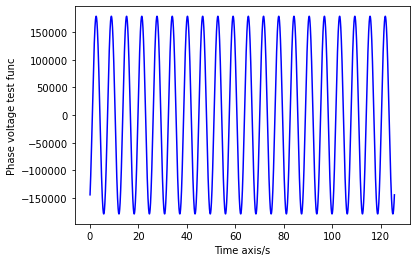

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import math as mt
import cmath as cmt
import scipy.integrate as odeint
%matplotlib inline
Data = (1/1000000)
#Sampling time



def main():
    
    Theta = np.pi/6
    ts = np.arange(0,0.4,Data)
    Angle = 2*np.pi*50*ts
    Vdc = 576
    
    func_1 = Vdc * np.sin(Angle - Theta)
    #Phase voltage
    func_2 = (Vdc/2) * np.sin(Angle)
    #Grid voltage
    
    Ls = 0.00200
    
    func_3 = (((Vdc * np.sin(Angle - Theta)) - ((Vdc/2) * np.sin(Angle))) / Ls)
    #Test
    plt.plot(Angle,func_3,'blue')
    plt.ylabel('Phase voltage test func')
    plt.xlabel('Time axis/s')
    plt.show()
    area = float(0)
    arr = []
    for i in range(1,len(func_3)):
        area = Data * ((func[i-1] - func[i]) / 2)
        arr.append(area)
        area = 0
        
    
    


if __name__ == "__main__":
    main()






